#### Experiment File Usage Handbook

Hints:  
1. Run `%load para.py` and it will load the code and default parameters from `para.py` directly into the same cell. Then, you can modify the parameters to experiment.  
  
2. Only modify the `parameters.json` is enough for the current stage. After modifying the root `parameters.json` file, the modifed file will be saved in the simulation result folder. The result folder is structured as `%d-%m-%Y&%H-%M-%S`

3. After modifying all `parameters.json`, adjust `vec1` if necessary. Then hit `Run All`. The results and parameters used to create the results are saved in the `run_results` folder.  
  
When to change the code: 
1. No need to change this notebook unless `vec1` is changed. If you want to change `vec1`, then change the respective code in Cell 1.  
2. If `main.py` is updated, then please reload the Cell 3. Reloading method refer to point 1.  

#### Cell 1: Load parameters

In [33]:
# %load variables.py
import scipy.special as sp
import pandas as pd
import numpy as np
import os
import json
with open("parameters.json", "r") as f:
    params = json.load(f)

year = params["year"] # simulation years
num_house = params["num_house"] # number of initial houses
land_cells = params["land_cells"] # initial amount of land cells
prod_multiplier = params["prod_multiplier"]
fishing_discount = params["fishing_discount"]
fallow_ratio = params["fallow_ratio"] # % of the total land
fallow_period = params["fallow_period"] # years
food_expiration_steps = params["food_expiration_steps"] # initial 3, by changing it from 3 to 2, everything changed a lot!
marriage_from = params["marriage_from"]
marriage_to = params["marriage_to"]
bride_price_ratio = params["bride_price_ratio"] # by changing it up, I haven't observed any changes yet
land_ecovery_rate = params["land_ecovery_rate"] # initial 0.03
land_max_capacity = params["land_max_capacity"] # initial 10
initial_quality = params["initial_quality"] # initial 5
fish_chance = params["fish_chance"] # initial 0.3
exchange_rate = params["exchange_rate"] # luxury to food # by changing it from 10 to 30, the gini changed a lot
luxury_good_storage = params["luxury_good_storage"] # initial 0
storage_ratio_low = params["storage_ratio_low"]
storage_ratio_high = params["storage_ratio_high"]
land_capacity_low = params["land_capacity_low"]
max_member = params["max_member"]
excess_food_ratio = params["excess_food_ratio"] # initial 2
trade_back_start = params["trade_back_start"]
lux_per_year = params["lux_per_year"] # initial 5 lowering it lower the gini coefficient
land_depreciate_factor = params["land_depreciate_factor"] # very important, when it was 0.01, the population died after 1000 years
fertility_scaler = params["fertility_scaler"] # very important, society cannot live up to 1000 yr if it is below 4 or 3. however, then the accumulative population is too much
file_path = params["file_path"]
file_name = params["file_name"]

vec1 = pd.read_csv('demog_vectors.csv')
vec1 = vec1.rename_axis('age').reset_index()
new_max_age = 60
old_max_age = vec1['age'].max()
scale_factor = new_max_age / old_max_age
scale_factor = 1
other_para = ['rho', 'pstar', 'mortparms']
bins = pd.cut(vec1['age'], bins=new_max_age)
binned_vec = pd.DataFrame()
for col in other_para:
    binned_col = vec1.groupby(bins).agg({col: 'mean'}).reset_index()
    binned_col[col] = binned_col[col] * scale_factor
    binned_vec[col] = binned_col[col]

bin_centers = [interval.mid for interval in binned_col['age']]
binned_vec = binned_vec.rename_axis('age_new').reset_index()
binned_vec['mstar'] = vec1['mstar']
binned_vec['fertparm'] = vec1['fertparm']
binned_vec['mortscale'] = vec1['mortscale']
binned_vec['fertscale'] = vec1['fertscale']
binned_vec['phi'] = vec1['phi']
vec1 = binned_vec

/var/folders/wr/956qfj8n0nd7qf20gnbgf5qw0000gn/T/ipykernel_64911/3688546571.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_col = vec1.groupby(bins).agg({col: 'mean'}).reset_index()
/var/folders/wr/956qfj8n0nd7qf20gnbgf5qw0000gn/T/ipykernel_64911/3688546571.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_col = vec1.groupby(bins).agg({col: 'mean'}).reset_index()
/var/folders/wr/956qfj8n0nd7qf20gnbgf5qw0000gn/T/ipykernel_64911/3688546571.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

#### Cell 2: Manage file system

In [34]:
import os
import datetime
timestamp = datetime.datetime.now().strftime("%d-%m-%Y&%H-%M-%S")
folder_name = f"run_results/{timestamp}"
file_name = f"{folder_name}/{file_name}"
file_path = f"{folder_name}/{file_path}"
os.makedirs(folder_name, exist_ok=True)
with open(os.path.join(folder_name, "parameters.json"), "w") as f:
    json.dump(params, f, indent=4)

#### Cell 3: Run the main.py


Simulation Year 0
Last year:130
village has 0 new born.

Simulation Year 1
Last year:130
village has 0 new born.

Simulation Year 2
Last year:130
village has 5 new born.

Simulation Year 3
Last year:134
village has 6 new born.

Simulation Year 4
Last year:140
village has 5 new born.

Simulation Year 5
Last year:143
village has 7 new born.

Simulation Year 6
Last year:146
village has 6 new born.

Simulation Year 7
Last year:150
village has 4 new born.

Simulation Year 8
Last year:152
village has 4 new born.

Simulation Year 9
Last year:154
village has 9 new born.

Simulation Year 10
Last year:159
village has 7 new born.

Simulation Year 11
Last year:163
village has 4 new born.

Simulation Year 12
Last year:166
village has 6 new born.

Simulation Year 13
Last year:169
village has 6 new born.

Simulation Year 14
Last year:172
village has 11 new born.

Simulation Year 15
Last year:177
village has 9 new born.

Simulation Year 16
Last year:182
village has 9 new born.

Simulation Year 17
Las

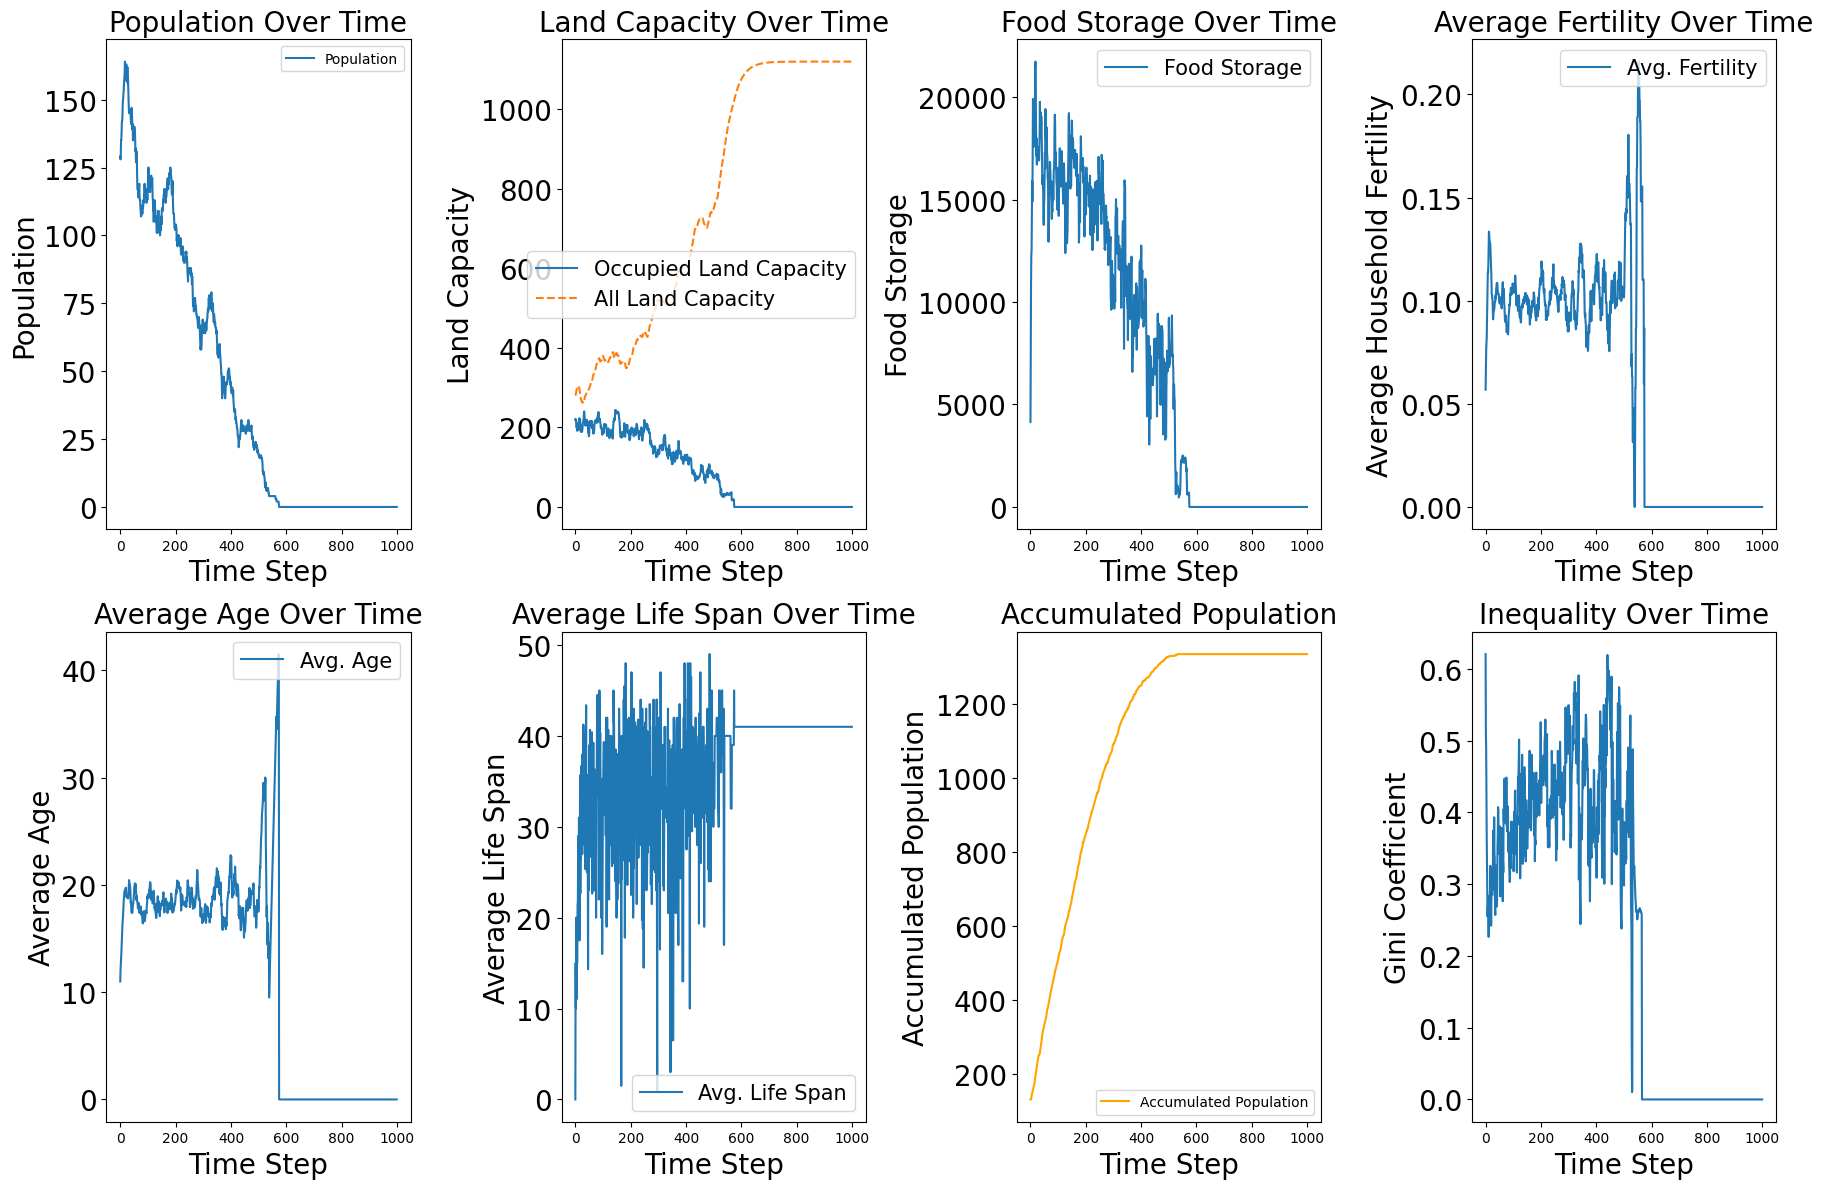

In [35]:
# %load main.py
from household import Household
from village import Village
from agent import Agent
from agent import Vec1
import pandas as pd
import utils
import random
import math
import sys
random.seed(10)

vec1_instance = Vec1()
village = utils.generate_random_village(num_house, land_cells, vec1_instance, food_expiration_steps, land_ecovery_rate, land_max_capacity, initial_quality, fish_chance, fallow_period)
village.initialize_network()
village.initialize_network_relationship()
for _ in range(year): 
    village.run_simulation_step(vec1_instance, prod_multiplier = prod_multiplier, fishing_discount = fishing_discount, fallow_ratio = fallow_ratio, fallow_period = fallow_period, food_expiration_steps = food_expiration_steps, marriage_from = marriage_from, marriage_to = marriage_to, bride_price_ratio = bride_price_ratio, exchange_rate = exchange_rate, storage_ratio_low=storage_ratio_low, storage_ratio_high=storage_ratio_high, land_capacity_low = land_capacity_low, max_member=max_member, excess_food_ratio = excess_food_ratio, trade_back_start = trade_back_start, lux_per_year = lux_per_year, land_depreciate_factor = land_depreciate_factor, fertility_scaler = fertility_scaler, spare_food_enabled=False, fallow_farming = True)
    # utils.print_village_summary(village)
    
village.plot_simulation_results(file_name)
village.generate_animation(file_path, grid_dim=math.ceil(math.sqrt(land_cells)))